<a href="https://colab.research.google.com/github/moonjune/test-repo/blob/master/rnn_many_to_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install tensorflow==1.12

In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib inline

print(tf.__version__)
tf.enable_eager_execution()

1.12.0


In [15]:
# 데이터 준비. 실제 쓰이는 단어와 그 단어에 좋다 나쁘다  태깅을 한 것
words = ['good', 'bad', 'worse', 'so good']
y_data = [1,0,0,1]

# 토큰 딕쇼너리를 만든다
char_set = ['<pad>'] + sorted(list(set(''.join(words))))
# 앞에 패드가 들어가는 이유는 워드 방식에선 <pad>를 한 요소로 사용하기 때문임. 
# 목적에 맞게 요소들은 추가될 것이며 추후 <seq>, <eos>등 다른 요소들도 추가 될거니 너무 신경쓰지 말 것
# 뒤의 것은 워즈 리스트에 있는 요소들을 쌩으로 합치고(join), 
# 이걸 각 문자를 원소로 하는 집합으로 합치고(set, ',' 구분자는 여기서 생김 + 중복 제거) 
# 그걸 리스트 화 하고(list), 정렬함(sort)
# 결과는 words 안에 있는 단어들을 스펠링과 <pad>를 원소로 하는 리스트 생성

#글자 단위로 글자 세트 생성
idx2char = {idx : char for idx, char in enumerate(char_set)}
# enumerate는 인덱스를 붙인 시퀀스로 생성해 줌 for문과 같이 쓰여서 [인덱스, 원래 원소] 이걸 순차적으로 반복해 줌
# :를 써도 되는지는 몰랐는데 딕셔너리 생성 시 활용
char2idx = {char : idx for idx, char in enumerate(char_set)}

print(char_set)
print(idx2char)
print(char2idx)


['<pad>', ' ', 'a', 'b', 'd', 'e', 'g', 'o', 'r', 's', 'w']
{0: '<pad>', 1: ' ', 2: 'a', 3: 'b', 4: 'd', 5: 'e', 6: 'g', 7: 'o', 8: 'r', 9: 's', 10: 'w'}
{'<pad>': 0, ' ': 1, 'a': 2, 'b': 3, 'd': 4, 'e': 5, 'g': 6, 'o': 7, 'r': 8, 's': 9, 'w': 10}


In [16]:
# 단어들을 만들어진 캐릭터 벡터 인덱스로 치환함
x_data = list(map(lambda word : [char2idx.get(char) for char in word], words))
# map 함수는 앞에는 함수, 뒤에는 인자를 받는다. 
# lambda 함수는 인스턴트 함수를 만들어 준다. 여기서 이용되는 것은 word를 받아서 word에 있는 걸 char로 받아서 전개
# 적용되는 함수는 char2idx.get(char)인데, ()안에 인자로 key 값을 넣으면 value를 반환해주는 함수이다.
# lambda word는 words의 스펠링 하나하나를 char로 받아 char2idx를 통해 key->value로 치환하고 그걸 리스트로 만든다

x_data_len = list(map(lambda word : len(word), x_data))
# x_data를 인자(word)로 받아서 각 단어들을 len에다 집어넣은 값 출력

print(x_data)
print(x_data_len)

[[6, 7, 7, 4], [3, 2, 4], [10, 7, 8, 9, 5], [9, 7, 1, 6, 7, 7, 4]]
[4, 3, 5, 7]


In [17]:
# 
max_sequence = 10
x_data = pad_sequences(sequences = x_data, maxlen = max_sequence,
                      padding = 'post', truncating = 'post')
# pad_sequences는 함수로 keras의 전처리를 위한 함수, 기초 인자는 시퀀스 데이터, 최대 시퀀스 길이, 등등..?
# padding은 하라는 거겠지만 post나 truncate post는 무슨 뜻인지 모르겠당
# padding: 패딩을 앞에 할 것인가(pre), 뒤로 할 것인가(post). 여기서는 뒤로 하기 위해 post
# truncating: 넘치는 글자를 어쩔것인가? 앞을 자를 거면 'pre', 뒤를 자를 거면 'post'
# 패딩 달아주는거. 기본 시퀀스 투입하고 최대 길이 정해주고, 패딩 어디 쌓을 건지 정하고(양옆은 없네), 넘치면 어떻게 자를건지 정해줌)

print(x_data)
print(x_data_len)
print(y_data)

[[ 6  7  7  4  0  0  0  0  0  0]
 [ 3  2  4  0  0  0  0  0  0  0]
 [10  7  8  9  5  0  0  0  0  0]
 [ 9  7  1  6  7  7  4  0  0  0]]
[4, 3, 5, 7]
[1, 0, 0, 1]


In [0]:

input_dim = len(char2idx)
# 사전의 크기
output_dim = len(char2idx)
# 역시 사전의 크기
one_hot = np.eye(len(char2idx))
# len(char2idx) * len(char2idx) 크기의 항등행렬을 만든다,
# 이 항등행렬을 만든 이유는 각 공간들의 주소값을 주기 위해서인듯 한데..

hidden_size = 10
num_classes = 2

model = Sequential()
# Sequential 객체 선언
model.add(layers.Embedding(input_dim = input_dim, output_dim = output_dim,
                           trainable = False, mask_zero = True, input_length = max_sequence,
                           embeddings_initializer = keras.initializers.Constant(one_hot)))
# keras 특유의 레이어 쌓기. 근데 인풋과 아웃풋 차원이 이미 정해져있네..
# rnn은 원래 한 시퀀스마다 결과를 뱉으니까 가능할 듯
# 아니 근데 이거 다대1아니었나? 그럼 마지막에 하나만 나오는거 아닌가?
# 그런 시비 보다는 일단 진도 빼자
# trainable이 뭐지; one hot을 학습시키지 않는다고 하였다. (1.13에선 변경된 듯)
# mask 제로는 연산에서 0이 된 것들을 제외한다고 하였다. mask 방법론이 적용되어 있으면 False로 0도 신경쓰게 하나..
# embeddings_initializer = keras.initializers.Constant(one_hot)가 첫 값인데, 이걸 업데이트 하지 않겠다고 봐야하나..
# 나중에 다시 보자
# 위 코드를 통해 input이 될 층을 쌓은 코드


model.add(layers.SimpleRNN(units = hidden_size))
# rnn 층 선언
model.add(layers.Dense(units = num_classes))
# 마지막 층을 도출하는 것으로 유닛 수를 num_class(2 == 좋다, 나쁘다)로 정해 클래시피케이션화 시킨 것

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 11)            121       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 10)                220       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 22        
Total params: 363
Trainable params: 242
Non-trainable params: 121
_________________________________________________________________


In [0]:
#모델 훈련
def loss_fn(model, x,y):
  return tf.losses.sparse_softmax_cross_entropy(labels = y, logits = model(x))
#기존엔 손실함수를 수식으로 썼다면 이번엔 tf가 제공하는 손실함수를 사용, model은 위에 정의된 sequence()에 레이어 추가된 거 말함

#옵티마이저 정의
lr = 0.01
epochs = 30
batch_size = 2
opt = tf.train.AdamOptimizer(learning_rate = lr)
# 아담 옵티마이저(유명)

In [21]:
#데이터 파이프라인 생성
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
tr_dataset = tr_dataset.shuffle(buffer_size = 4)
tr_dataset = tr_dataset.batch(batch_size = batch_size)
# tr_dataset은 tf.data.Dataset.from_tensor_slices로 구성된다. 일단 여러 텐서를 동시에 올릴 수 있다고 한다.
# 큰 건 돌리지 말라고 한다. 한번에 메모리에 올려버리는 거라서
# 일단 데이터를 한행 한행 잘라주는 거라고 한다. for 문을 대체하기 위한 걸까?

# shuffle은 섞어주는 건데 일정 크기에 데이터 할당해 섞는다고 한다. 그 인수(buffer_size)가 더 커야 한다고 함
# batch는 아는 대로 한번에 몇 개씩 넣을건지 정하는 거... 걍 뭐 그런 것이다

# 간략하게 tf.data는 딥러닝을 위해 특화된 데이터 함수고 셔플이나 배치 등 데이터 변형 입력 등을 편리하게 해주는 함수로 보임  

print(tr_dataset)

<BatchDataset shapes: ((?, 10), (?,)), types: (tf.int32, tf.int32)>


In [22]:
#훈련
tr_loss_hist = []
# 그래프 그리기용 히스토리

for epoch in range(epochs):
  avg_tr_loss = 0
  tr_step = 0
  # avg_tr_loss 변수 값 선언 후 단계별 손실값을 더하고 스텝별로 나누는 걸로 줄여나감
  # tr_step은 epoch랑 같은 것
  for x_mb, y_mb in tr_dataset:
    with tf.GradientTape() as tape:
      tr_loss = loss_fn(model, x = x_mb, y=y_mb)
    grads = tape.gradient(target = tr_loss, sources = model.variables)
    opt.apply_gradients(grads_and_vars = zip(grads, model.variables))
    avg_tr_loss += tr_loss
    tr_step += 1
  else:
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
  # mb 뜻은 모르지만 걍 변수명으로 가고 손실함수에 앞서 정의된 rnn 모델과 x값 y값을 투입
  # grads는 위의 gradienttape를 이용해서 tr_loss를 model.variable 값으로 미분.. 
  # model.variables는 무엇일까? 모델이 받은 변수일까 생성한 변수일까..
  if (epoch + 1) % 5 == 0:
    print('epoch : {:3}, tr_loss: {:.3f}'.format(epoch + 1, avg_tr_loss))
      

epoch :   5, tr_loss: 0.380
epoch :  10, tr_loss: 0.108
epoch :  15, tr_loss: 0.036
epoch :  20, tr_loss: 0.016
epoch :  25, tr_loss: 0.009
epoch :  30, tr_loss: 0.007


In [25]:
print(model.variables)
# 모델 변수 자체를 출력해보면 아래와 같다.
# 먼저 나오는 행렬은 (11,10) 형태의 행렬이다. 11은 embedingg된 토큰 포함 알파벳 수, 10은 임의로 생성한 히든 사이즈이다.
# 두번째로 나온 행렬은 (10,10) 형태의 행렬이다. '
# 대충 A<2-1>(kernel:0), Waa(recurrent_kernel:0), ba(bias:0), Wax(embeddings), Way(dens:kernel), by(dense: bias:0) 일 것이다. 
# 위의 변수들을 조정해서 기울기 값을 최소로 하니까..

[<tf.Variable 'simple_rnn_1/kernel:0' shape=(11, 10) dtype=float32, numpy=
array([[-0.21474013, -0.10649455,  0.09093869,  0.2855053 ,  0.3593501 ,
        -0.15914246,  0.5344489 , -0.465375  ,  0.1383636 , -0.3194853 ],
       [-0.654219  ,  0.44047308, -0.24638326,  0.07234649, -0.13072936,
         0.03919677, -0.15056534, -0.29604545, -0.23578192,  0.5514661 ],
       [ 0.60564905, -0.2300493 ,  0.1465909 ,  0.38299823, -0.00921232,
        -0.11388415, -0.04110971,  0.19311957,  0.05711955, -0.04855765],
       [ 0.4798396 ,  0.56426114,  0.24165556,  0.27575386,  0.5888763 ,
         0.2687913 , -0.40175882, -0.32942405, -0.01361054,  0.37093264],
       [-0.44618788, -0.25219774,  0.09859213,  0.1559581 ,  0.12820792,
         0.26009184, -0.30979759,  0.2897816 ,  0.3967795 , -0.00939598],
       [-0.28490815, -0.23065552,  0.2862044 ,  0.2936403 , -0.02459965,
         0.03557006, -0.19624577,  0.56277865,  0.12202628, -0.16169451],
       [ 0.28984466,  0.00817176, -0.518646

In [26]:
 print(tr_loss)

tf.Tensor(0.0077197216, shape=(), dtype=float32)


In [32]:
yhat = model.predict(x_data)
# 모델의 훈련은 위의 과정을 통해 마무리. 훈련된 가중치는 현재 모델 안에 있는데..
# 추후엔 이 모델만 따로 저장하고 다른 곳에선 훈련된 가중치만 쓸 줄 알아야 함
yhat = np.argmax(yhat, axis = -1)
print(yhat)
$
print('acc : {:.2%}'.format(np.mean(yhat == y_data)))

[1 0 0 1]
acc : 100.00%


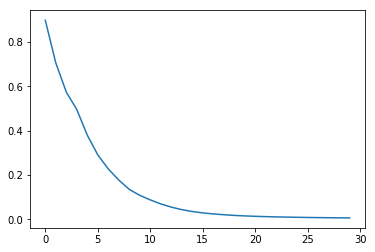

In [33]:
plt.plot(tr_loss_hist)

In [0]:
tf.train.Saver()